# Use MyModel-IDEAL Model

In [69]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import torch
import torch.nn as nn
import tomli
import matplotlib.pyplot as plt
from os import environ
from pathlib import Path
from buildings_bench import load_torch_dataset
from buildings_bench.models import model_factory

In [70]:
class DataHandler:
    def __init__(self): pass

    def load_dataset(self, dataset_name, scaler_transform):
        dataset = load_torch_dataset(
            name=dataset_name,
            apply_scaler_transform=scaler_transform,
            scaler_transform_path=Path(environ["TRANSFORM_PATH"])
        )
        return dataset

    def create_dataloader(self, building_dataset):
        dataloader = torch.utils.data.DataLoader(
                        building_dataset,
                        batch_size=360,
                        shuffle=False)
        return dataloader

In [71]:
class MLP(nn.Module):    
    def __init__(self,
                 hidden_size=3,
                 context_len=168,
                 pred_len=24,
                 continuous_loads=True,
                 **args):
        super().__init__()

        self.context_len=context_len
        self.hidden_size=hidden_size
        self.pred_len=pred_len
        self.continuous_loads=continuous_loads

        self.mlp = nn.Sequential(
            nn.Linear(context_len, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, pred_len*2)
        )

    def forward(self, x):
        x = x['load'][:, :self.context_len, 0] # (batch_size, self.context_len)
        out = self.mlp(x)  # (batch_size, self.pred_len*2)
        return out.view(-1, self.pred_len, 2) # (batch_size, self.pred_len, 2)
   

    def predict(self, x):
        out = self.forward(x)
        means = out[:, :, 0].unsqueeze(2)
        stds = nn.functional.softplus(out[:, :, 1].unsqueeze(2))
        return means, torch.cat([means, stds], dim=2)

import torch
import torch.nn as nn

class RNN(nn.Module):    
    def __init__(self,
                 hidden_size=3,
                 lstm_layers=1,
                 context_len=168,
                 pred_len=24,
                 continuous_loads=True,
                 **args):
        super().__init__()

        self.context_len = context_len
        self.hidden_size = hidden_size
        self.pred_len = pred_len
        self.continuous_loads = continuous_loads
        self.lstm_layers = lstm_layers

        self.power_embedding = nn.Linear(1, 64)
        self.building_embedding = nn.Embedding(2, 32)
        self.lat_embedding = nn.Linear(1, 32)
        self.lon_embedding = nn.Linear(1, 32)

        self.encoder = nn.LSTM(160, hidden_size, num_layers=lstm_layers, batch_first=True)
        self.decoder = nn.LSTM(160, hidden_size, num_layers=lstm_layers, batch_first=True)
        self.output_layer = nn.Linear(hidden_size, 1)  # Final prediction

    def forward(self, x):
        # Embedding input features
        lat = self.lat_embedding(x['latitude'])                  # [B, T, 32]
        lon = self.lon_embedding(x['longitude'])                 # [B, T, 32]
        btype = self.building_embedding(x['building_type'].squeeze(-1))  # [B, T, 32]
        load = self.power_embedding(x['load'])     # [B, T, 64]

        time_series_inputs = [lat, lon, btype, load]

        # Concatenate all embeddings
        time_series_embed = torch.cat(time_series_inputs, dim=2)  # [B, T, 256]

        # Encode context sequence
        context_seq = time_series_embed[:, :self.context_len, :]  # [B, 168, 256]
        _, (h_n, c_n) = self.encoder(context_seq)  # hidden and cell states for decoder

        # Prepare decoder input (repeat last context embedding)
        decoder_input = time_series_embed[:, self.context_len - 1:self.context_len, :].repeat(1, self.pred_len, 1)

        # Decode
        decoder_out, _ = self.decoder(decoder_input, (h_n, c_n))  # [B, 24, hidden_size]
        
        return decoder_out

    def predict(self, x):
        out = self.forward(x)
        output = self.output_layer(out).squeeze(-1)  # [B, 24]
        return output

In [82]:
def train(model_name, train_dataset, scaler_transform, device, optimizer='adam', loss='mse'):
    handler = DataHandler()
    dataset = handler.load_dataset(train_dataset, scaler_transform)    

    if model_name == 'MLP':
        model = MLP().to(device)
    elif model_name == 'RNN':
        model = RNN().to(device)
        
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    model.train()
    for epoch in range(10):
        for building_id, building_dataset in dataset:
            inverse_transform = building_dataset.datasets[0].load_transform.undo_transform
            dataloader = handler.create_dataloader(building_dataset)
            
            for batch in dataloader:
                for key, value in batch.items():
                    batch[key] = value.to(device)
                    
                optimizer.zero_grad()
                predictions = model(batch)
                targets = batch['load'][:, 168:, 0]  # ground truth
                loss = loss_fn(predictions[:, :, 0], targets)
                loss.backward()
                optimizer.step()
      
    return model

In [87]:
def test(model, model_name, test_dataset, scaler_transform, device):
    handler = DataHandler()
    dataset = handler.load_dataset(test_dataset, scaler_transform)    

    model = model.to(device)
    
    target_list = []
    prediction_list = []

    model.eval()
    for building_id, building_dataset in dataset:
            
        inverse_transform = building_dataset.datasets[0].load_transform.undo_transform
        dataloader = handler.create_dataloader(building_dataset)
            
        for batch in dataloader:
            for key, value in batch.items():
                batch[key] = value.to(device)

            with torch.no_grad():
                predictions = model.predict(batch)
  
        targets = batch['load'][:, 168:]
        targets = inverse_transform(targets)
        target_list.append(targets.detach().cpu())

        if model_name = 'RNN':
            predictions = inverse_transform(predictions)
        if model_name = 'MLP'
            predictions = inverse_transform(predictions[0])
        prediction_list.append(predictions.detach().cpu())

    prediction_list = torch.cat(prediction_list)
    target_list = torch.cat(target_list)
    
    return prediction_list, target_list

In [88]:
def main(model_name, train_dataset, test_dataset, scaler_transform, device):
    
    model = train(model_name=model_name, train_dataset=train_dataset, scaler_transform=scaler_transform, device=device, optimizer='adam', loss='mse')
    
    test_dataset = 'sceaux'
    preds, targets = test(model=model, model_name=model_name, test_dataset=test_dataset, scaler_transform=scaler_transform, device=device)
    plt.plot(preds[0].squeeze(), label="Prediction")
    plt.plot(targets[0].squeeze(), label="Target")
    plt.legend()
    plt.show()
    
    test_dataset = 'electricity'
    preds, targets = test(model=model, model_name=model_name, test_dataset=test_dataset, scaler_transform=scaler_transform, device=device)
    plt.plot(preds[0].squeeze(), label="Prediction")
    plt.plot(targets[0].squeeze(), label="Target")
    plt.legend()
    plt.show()
    
    test_dataset = 'smart'
    preds, targets = test(model=model, model_name=model_name, test_dataset=test_dataset, scaler_transform=scaler_transform, device=device)
    plt.plot(preds[0].squeeze(), label="Prediction")
    plt.plot(targets[0].squeeze(), label="Target")
    plt.legend()
    plt.show()

In [89]:
if __name__ == "__main__":

    # Ideal | SMART
    # Ideal | electricity
    # Ideal | sceaux
    train_dataset = 'ideal' # Electricity | SMART | Ideal | lcl 
    device = 'cuda:0'
    model_name = 'RNN' # MLP
    scaler_transform = 'boxcox'

    PATH = '/pscratch/sd/n/nrushad'
    environ["PATH"] = PATH
    environ["REPO_PATH"] = f'{PATH}/BuildingsBenchTutorial/BuildingsBench/'
    environ["BUILDINGS_BENCH"] = f'{PATH}/Dataset'
    environ["TRANSFORM_PATH"] = f'{PATH}/Dataset/metadata/transforms'

    model = main(model_name=model_name, train_dataset=train_dataset, test_dataset=test_dataset, scaler_transform=scaler_transform, device=device)

In [37]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from buildings_bench import load_torch_dataset
from os import environ
from pathlib import Path

# === DATA HANDLER ===
class DataHandler:
    def __init__(self, batch_size=32):
        self.batch_size = batch_size

    def load_dataset(self, dataset_name, scaler_transform):
        return list(load_torch_dataset(
            dataset_name,
            apply_scaler_transform=scaler_transform,
            scaler_transform_path=Path(environ["TRANSFORM_PATH"])
        ))

    def create_dataloader(self, dataset):
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=False)

# === MODEL WRAPPER ===
class Model:
    class MLP(nn.Module):    
        def __init__(self, hidden_size=3, context_len=168, pred_len=24, continuous_loads=True, **kwargs):
            super().__init__()
            self.context_len = context_len
            self.hidden_size = hidden_size
            self.pred_len = pred_len
            self.continuous_loads = continuous_loads
            self.mlp = self._build_mlp()

        def _build_mlp(self):
            return nn.Sequential(
                nn.Linear(self.context_len, self.hidden_size),
                nn.ReLU(),
                nn.Linear(self.hidden_size, self.pred_len * 2)
            )

        def forward(self, x):
            x = x['load'][:, :self.context_len, 0]
            out = self.mlp(x)
            return out.view(-1, self.pred_len, 2)

        def predict(self, x):
            out = self.forward(x)
            return out[:, :, 0].unsqueeze(2)

            

# === TRAINING + EVALUATION WRAPPER ===
class Trainer:
    def __init__(self, model_name, device, scaler_transform):
        self.model_name = model_name
        self.device = device
        self.scaler_transform = scaler_transform
        self.model = self._load_model()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.loss_fn = nn.MSELoss()
        self.handler = DataHandler(batch_size=32)

    def _load_model(self):
        if self.model_name == 'MLP':
            return Model.MLP().to(self.device)
        elif self.model_name == 'RNN':
            return RNN().to(self.device)
        else:
            raise ValueError(f"Unsupported model: {self.model_name}")

    def train(self, train_buildings):
        self.model.train()
        for epoch in range(2):
            total_loss = 0.0
            for building_id, building_dataset in train_buildings:
                dataloader = self.handler.create_dataloader(building_dataset)

                for batch in dataloader:
                    for key, value in batch.items():
                        batch[key] = value.to(self.device)

                    self.optimizer.zero_grad()
                    predictions = self.model(batch)
                    targets = batch['load'][:, 168:, 0]
                    loss = self.loss_fn(predictions[:, :, 0], targets)
                    loss.backward()
                    self.optimizer.step()
                    total_loss += loss.item()

            print(f"Epoch {epoch + 1}: Loss = {total_loss:.4f}")
        self.model.eval()
        return self.model

    def evaluate(self, test_buildings):
        self.model.eval()
        results = {}

        for building_id, building_dataset in test_buildings:
            
            inverse_transform = building_dataset.datasets[0].load_transform.undo_transform
            dataloader = self.handler.create_dataloader(building_dataset)

            target_list = []
            prediction_list = []

            with torch.no_grad():
                for batch in dataloader:
                    for key, value in batch.items():
                        batch[key] = value.to(self.device)

                    predictions = self.model.predict(batch)
                    targets = batch['load'][:, 168:]

                    targets = inverse_transform(targets)
                    predictions = inverse_transform(predictions)  # (B, pred_len)

                    prediction_list.append(predictions.detach().cpu())
                    target_list.append(targets.detach().cpu())

            predictions_all = torch.cat(prediction_list)
            targets_all = torch.cat(target_list)
            results[building_id] = (predictions_all, targets_all)

        return results

# === ENVIRONMENT SETUP ===
dataset_name = "ideal"
scaler_transform = 'boxcox'
PATH = '/pscratch/sd/n/nrushad'

environ["PATH"] = PATH
environ["REPO_PATH"] = f'{PATH}/BuildingsBenchTutorial/BuildingsBench/'
environ["BUILDINGS_BENCH"] = f'{PATH}/Dataset'
environ["TRANSFORM_PATH"] = f'{PATH}/Dataset/metadata/transforms'

# === LOAD AND SPLIT DATA ===
handler = DataHandler(batch_size=32)
all_buildings = handler.load_dataset(dataset_name, scaler_transform)

total = len(all_buildings)
train_count = int(0.8 * total)

train_buildings = all_buildings[:train_count]
test_buildings = all_buildings[train_count:]

# === TRAINING ===
trainer = Trainer(model_name='MLP', device='cuda:0', scaler_transform=scaler_transform)
model = trainer.train(train_buildings)

# === EVALUATION ===
results = trainer.evaluate(test_buildings)

# === PRINT SAMPLE OUTPUT ===
for building_id, (pred, target) in results.items():
    print(f"Building ID: {building_id} | Predictions: {pred.shape}, Targets: {target.shape}")
    break

Epoch 1: Loss = 1189.7495
Epoch 2: Loss = 311.9016
Building ID: home328 | Predictions: torch.Size([80, 24, 1]), Targets: torch.Size([80, 24, 1])


Building ID: home328 | Predictions: torch.Size([80, 24, 1]), Targets: torch.Size([80, 24, 1])


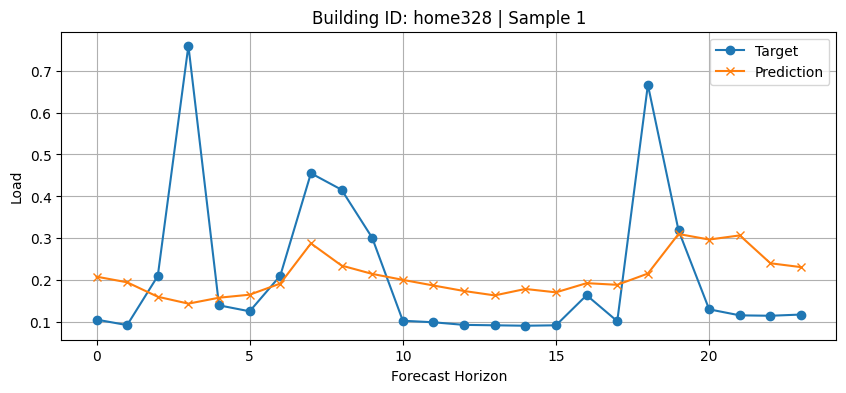

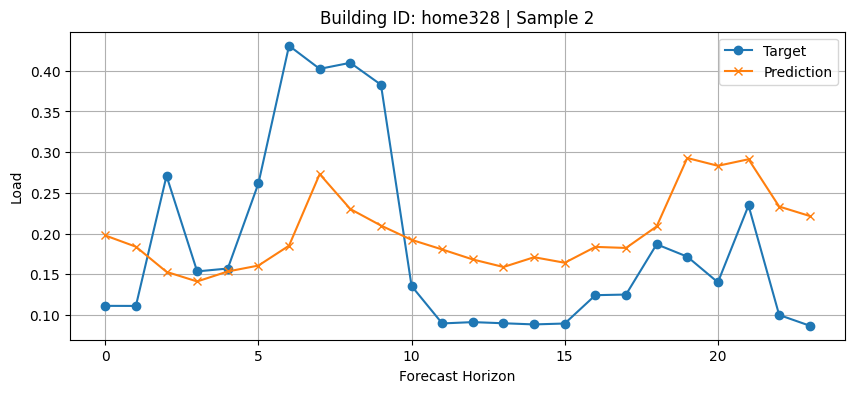

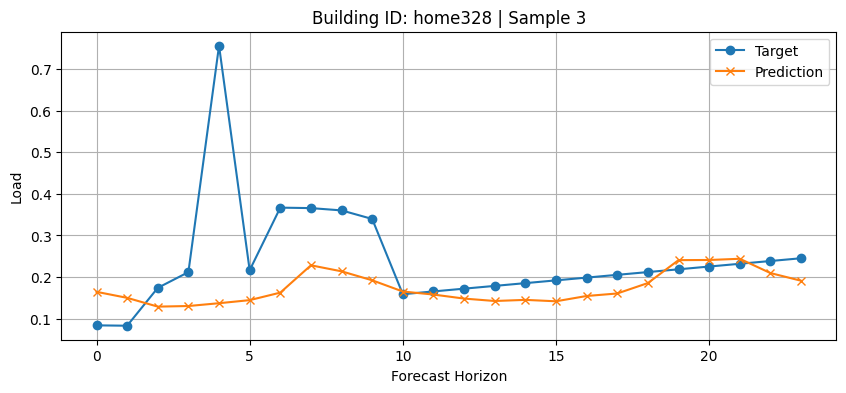

In [40]:
import matplotlib.pyplot as plt

def plot_predictions(building_id, predictions, targets, num_samples=1):
        """
        Plot predictions vs. targets for a building.
        Assumes predictions and targets shape: [batch, pred_len, 1]
        """
        predictions = predictions[:num_samples].squeeze(-1)  # [num_samples, pred_len]
        targets = targets[:num_samples].squeeze(-1)

        for i in range(predictions.shape[0]):
            plt.figure(figsize=(10, 4))
            plt.plot(targets[i].cpu().numpy(), label='Target', marker='o')
            plt.plot(predictions[i].cpu().numpy(), label='Prediction', marker='x')
            plt.title(f'Building ID: {building_id} | Sample {i+1}')
            plt.xlabel('Forecast Horizon')
            plt.ylabel('Load')
            plt.legend()
            plt.grid(True)
            plt.show()

for building_id, (pred, target) in results.items():
    print(f"Building ID: {building_id} | Predictions: {pred.shape}, Targets: {target.shape}")
    plot_predictions(building_id, pred, target, num_samples=3)
    break